In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from os import listdir
from os.path import isfile, join
from soma_rabies_somadetector_data import brain2paths, brain2centers
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


In [2]:
brain = "8557"
channel = "3channel"
dir = brain2paths[brain][0]
vol_fg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][1]
vol_bg = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
dir = brain2paths[brain][2]
vol_endo = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)
print(vol_fg.shape)

soma_centers = brain2centers[brain][0][0]
nonsoma_centers = brain2centers[brain][1][0]

print(f"{len(soma_centers)} soma centers")
print(f"{len(nonsoma_centers)} nonsoma centers")


(5602, 7360, 3300, 1)
100 soma centers
29 nonsoma centers


## Examine

In [3]:

dir = brain2paths[brain][0]
vol_fg = CloudVolume(dir, parallel=1, mip=3, fill_missing=False)
print(vol_fg.shape)

scale = [i/1000 for i in vol_fg.resolution]
scale[2] = 4*scale[2]

(701, 920, 3300, 1)


In [4]:
im = np.squeeze(np.array(vol_fg[:,:,:]))

from scipy.ndimage import zoom
new_array = zoom(im, (1, 1, 0.25))

Downloading: 100%|██████████| 3300/3300 [00:50<00:00, 65.79it/s]


In [9]:
new_array[:,:,630:] = 0

In [14]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(new_array, scale = scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## Save images

In [ ]:
dset_name = "BSsomas_train"

type = "pos"
for i, center in enumerate(soma_centers):
    if i <10:
        pass
    else:
        continue
    image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_fg = image_fg[:,:,:,0]
    image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_bg = image_bg[:,:,:,0]
    image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_endo = image_endo[:,:,:,0]

    image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image)
        

In [ ]:
type = "neg"
for i, center in enumerate(nonsoma_centers):
    if i < 10:
        pass
    else:
        continue
    image_fg = vol_fg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_fg = image_fg[:,:,:,0]
    image_bg = vol_bg[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_bg = image_bg[:,:,:,0]
    image_endo = vol_endo[center[0]-24:center[0]+25,center[1]-24:center[1]+25, center[2]-24:center[2]+25]
    image_endo = image_endo[:,:,:,0]


    image = np.squeeze(np.stack([image_fg, image_bg, image_endo], axis=0))
        
    fname = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/{dset_name}/{int(center[0])}_{int(center[1])}_{int(center[2])}_{type}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_3channel", data=image)

## Evaluate performance

In [ ]:
recalls = []
precisions = []

files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/test/"
onlyfiles = [f for f in listdir(files_dir) if isfile(join(files_dir, f))]
#test_files = [f for f in onlyfiles if f[:4] == "test"]
test_files = [f for f in onlyfiles if "Probabilities" in f] #"probabilities"
print(test_files)

size_thresh = 500

thresholds = list(np.arange(0.0,1.0,0.02))

for threshold in thresholds:
    tot_pos = 0
    true_pos = 0
    false_pos = 0
    for filename in tqdm(test_files, disable=True):
        if filename == "3972_1636_1575_pos_Probabilities.h5":
            newpos = 2
        else:
            newpos = 1

        fname = files_dir + filename
        f = h5py.File(fname, "r")
        pred = f.get("exported_data")
        pred = pred[0,:,:,:]
        mask = pred>threshold
        labels = measure.label(mask)
        props = measure.regionprops(labels)

        if "pos" in filename: 
            num_detected = 0
            tot_pos += newpos
            for prop in props:
                if prop["area"] > size_thresh:
                    if num_detected < newpos:
                        true_pos += 1
                        num_detected += 1
                    else:
                        false_pos += 1
        elif "neg" in filename:
            for prop in props:
                if prop["area"] > size_thresh:
                    false_pos += 1

    recall = true_pos/tot_pos
    recalls.append(recall)
    if true_pos + false_pos == 0:
        precision = 0
    else:
        precision = true_pos/(true_pos + false_pos)
    precisions.append(precision)
    if precision == 0 and recall == 0:
        fscore = 0
    else:
        fscore = 2*precision*recall/(precision+recall)
    print(f"threshold: {threshold}: precision: {precision}, recall: {recall}, f-score: {fscore} for {tot_pos} positive samples in {len(test_files)} images")

fscores = [2*precision*recall/(precision+recall) if (precision != 0 and recall != 0) else 0 for precision,recall in zip(precisions, recalls) ]
dict = {'Recall': recalls, 'Precision' : precisions, 'F-score': fscores, 'Threshold': thresholds}
df = pd.DataFrame(dict)
max_fscore = df["F-score"].max()
best_threshold = float(df.loc[df['F-score'] == max_fscore]['Threshold'].iloc[0])
best_rec = float(df.loc[df['F-score'] == max_fscore]['Recall'].iloc[0])
best_prec = float(df.loc[df['F-score'] == max_fscore]['Precision'].iloc[0])
sns.set(font_scale=2)

plt.figure(figsize = (8,8))
sns.lineplot(data=df, x="Recall", y="Precision", estimator=np.amax, ci=False)
plt.scatter(best_rec, best_prec, c='r', label=f"Max f-score: {max_fscore:.2f} thresh:{best_threshold:.2f}")
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.title(f"Brain {brain} Validation: {tot_pos}+ {len(test_files)-tot_pos}-")
plt.legend()

## All validation for paper

['2260_3006_1211_pos_Probabilities.h5', '3005_3506_1550_neg_Probabilities.h5', '1970_2762_1783_pos_Probabilities.h5', '2207_2611_1530_pos_Probabilities.h5', '1830_3484_708_pos_Probabilities.h5', '1854_3435_707_pos_Probabilities.h5', '1580_2845_1371_pos_Probabilities.h5', '757_5052_1364_neg_Probabilities.h5', '1956_2558_1524_pos_Probabilities.h5', '2091_2580_1613_pos_Probabilities.h5', '1680_2866_1531_pos_Probabilities.h5', '1758_2692_1914_pos_Probabilities.h5', '2433_2691_1217_pos_Probabilities.h5', '3086_4087_1875_neg_Probabilities.h5', '1102_1870_1854_neg_Probabilities.h5', '2150_5722_1364_neg_Probabilities.h5', '1972_2370_1661_pos_Probabilities.h5', '1847_3412_1539_pos_Probabilities.h5', '2897_3204_1300_neg_Probabilities.h5', '1359_782_2442_neg_Probabilities.h5', '2055_2577_1609_pos_Probabilities.h5', '1945_2710_1345_pos_Probabilities.h5', '1650_2605_1644_pos_Probabilities.h5', '3049_5896_1018_pos_Probabilities.h5', '1654_2980_1376_pos_Probabilities.h5', '1714_2647_1904_pos_Probabil

<AxesSubplot:xlabel='Recall', ylabel='Precision'>

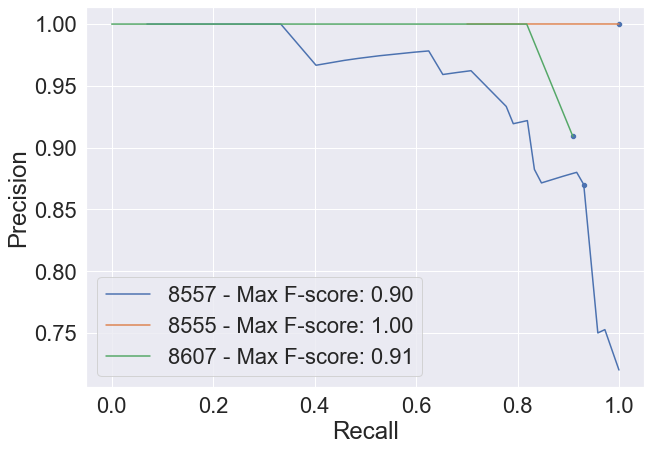

In [13]:
channel = "3channel"
brains = ["8557", "8555", "8607"]

recalls = []
precisions = []
brain_ids = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain in brains:

    files_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/brain{brain}/{channel}/test/"
    onlyfiles = [f for f in listdir(files_dir) if isfile(join(files_dir, f))]
    #test_files = [f for f in onlyfiles if f[:4] == "test"]
    test_files = [f for f in onlyfiles if "Probabilities" in f] #"probabilities"
    print(test_files)

    best_fscore = 0

    size_thresh = 500

    thresholds = list(np.arange(0.0,1.0,0.02))

    for threshold in thresholds:
        tot_pos = 0
        true_pos = 0
        false_pos = 0
        for filename in tqdm(test_files, disable=True):
            if filename == "3972_1636_1575_pos_Probabilities.h5":
                newpos = 2
            else:
                newpos = 1

            fname = files_dir + filename
            f = h5py.File(fname, "r")
            pred = f.get("exported_data")
            pred = pred[0,:,:,:]
            mask = pred>threshold
            labels = measure.label(mask)
            props = measure.regionprops(labels)

            if "pos" in filename: 
                num_detected = 0
                tot_pos += newpos
                for prop in props:
                    if prop["area"] > size_thresh:
                        if num_detected < newpos:
                            true_pos += 1
                            num_detected += 1
                        else:
                            false_pos += 1
            elif "neg" in filename:
                for prop in props:
                    if prop["area"] > size_thresh:
                        false_pos += 1

        recall = true_pos/tot_pos
        recalls.append(recall)
        if true_pos + false_pos == 0:
            precision = 1
        else:
            precision = true_pos/(true_pos + false_pos)

        precisions.append(precision)
        if precision == 0 and recall == 0:
            fscore = 0
        else:
            fscore = 2*precision*recall/(precision+recall)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision
            best_recall = recall

        brain_ids.append(brain)
    best_fscores[brain] = best_fscore
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)


for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {'Sample' : brain_ids, 'Recall': recalls, 'Precision' : precisions}
df = pd.DataFrame(data = data)

sns.set(rc={'figure.figsize':(10,7)})
sns.set(font_scale=2)
sns.lineplot(data = df, x = "Recall", y = "Precision", hue="Sample", estimator='max', ci=None)
sns.scatterplot(x=best_recalls, y=best_precisions)

In [ ]:
for filename in tqdm(test_files, disable=True):
    print(f"*************File: {filename}*********")
    if filename == "3972_1636_1575_pos_Probabilities.h5":
        newpos = 2
    else:
        newpos = 1

    im_fname = files_dir + filename[:-17] + ".h5"
    fname = files_dir + filename
    f = h5py.File(fname, "r")
    pred = f.get("exported_data")
    pred = pred[0,:,:,:]
    mask = pred>best_threshold
    labels = measure.label(mask)
    props = measure.regionprops(labels)

    if "pos" in filename: 
        num_detected = 0
        tot_pos += newpos
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"area of detected object: {area}")
                if num_detected < newpos:
                    true_pos += 1
                    num_detected += 1
                else:
                    print(f"Soma false positive Area: {area}")
                    f = h5py.File(im_fname, "r")
                    im = f.get("image_3channel")
                    viewer = napari.Viewer(ndisplay=3)
                    viewer.add_image(im[0,:,:,:])
                    viewer.add_image(im[1,:,:,:])
                    viewer.add_image(im[2,:,:,:])
                    viewer.add_labels(mask)
                    viewer.add_labels(labels == prop["label"], name=f"soma false positive area: {area}")
                    false_pos += 1
        if num_detected == 0:
            print(f"Soma false negative")
            f = h5py.File(im_fname, "r")
            im = f.get("image_3channel")
            viewer = napari.Viewer(ndisplay=3)
            viewer.add_image(im[0,:,:,:])
            viewer.add_image(im[1,:,:,:])
            viewer.add_image(im[2,:,:,:])
            viewer.add_labels(mask, name="Soma false negative")
    elif "neg" in filename:
        for prop in props:
            area = prop["area"]
            if area > size_thresh:
                print(f"Nonsoma false positive Area: {area}")
                f = h5py.File(im_fname, "r")
                im = f.get("image_3channel")
                viewer = napari.Viewer(ndisplay=3)
                viewer.add_image(im[0,:,:,:])
                viewer.add_image(im[1,:,:,:])
                viewer.add_image(im[2,:,:,:])
                viewer.add_labels(mask)
                viewer.add_labels(labels == prop["label"], name=f"nonsoma false positive area: {area}")
                false_pos += 1

In [ ]:
best_threshold

## make point layer - ?????

In [ ]:

point_path = "precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/point_preds"
info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    # raw, jpeg, compressed_segmentation, fpzip, kempressed, compresso
    encoding        = 'raw', 
    resolution      = [4, 4, 40], # Voxel scaling, units are in nanometers
    voxel_offset    = [0, 0, 0], # x,y,z offset in voxels from the origin
    mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 512, 512, 16 ], # units are voxels
    volume_size     = [ 250000, 250000, 25000 ], # e.g. a cubic millimeter dataset
)
vol = CloudVolume(point_path, info=info)
vol.commit_info()

In [ ]:
new_somas = []
for soma in somas:
    if soma[2] <= 3000:
        new_somas.append(soma)
len(new_somas)

In [ ]:
soma_ra = np.array(new_somas)
plt.hist(soma_ra[:,2])

In [ ]:
import napari
viewer = napari.Viewer(ndisplay=3)

# Download slices

In [ ]:
im_fg = vol_fg[3100:3500,4500:4900,1400:1800, 0]
im_bg = vol_bg[3100:3500,4500:4900,1400:1800, 0]
im_endo = vol_endo[3100:3500,4500:4900,1400:1800, 0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(im_fg))
viewer.add_image(np.squeeze(im_bg))
viewer.add_image(np.squeeze(im_endo))

## Check ilastik

In [ ]:
im_fg = vol_fg[3100:3500,4500:4900,1400:1800, 0]
im_bg = vol_bg[3100:3500,4500:4900,1400:1800, 0]
im_endo = vol_endo[3100:3500,4500:4900,1400:1800, 0]

image = np.squeeze(np.stack([im_fg, im_bg, im_endo], axis=0))
fname = "/Users/thomasathey/Desktop/im.h5"

with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_3channel", data=image)

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh", "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/matt_soma_rabies_pix_3ch.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)



In [ ]:
f = h5py.File("/Users/thomasathey/Desktop/im_Probabilities.h5", "r")
pred = f.get("exported_data")

pred = pred[0,:,:,:]

mask = pred > 0.55
labels = measure.label(mask)
props = measure.regionprops(labels)

results = []
for prop in props:
    if prop["area"] > 500:
        location = list(np.add((0,0,0), prop["centroid"]))
        print(location)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.squeeze(im_fg))
viewer.add_labels(mask)

In [ ]:
import math
import numpy as np
new_pts = []
for point in a:
    first = math.isclose(point[0],int(point[0]))
    second = math.isclose(np.abs(point[1]-int(point[1])), 0.5)
    third = math.isclose(np.abs(point[2]-int(point[2])), 0.5)
    if first and second and third:
        continue
    else:
        new_pts.append(point)

In [ ]:
from cloudvolume import CloudVolume
import numpy as np
from skimage import io
import napari

subvol_number = -1 #change value here for different center point, valid values 0-9
r = 400 #change for voxel radius

vol = CloudVolume("precomputed://https://dlab-colm.neurodata.io/2021_10_06/8557/Ch_647", parallel=1, mip=0, fill_missing=False)
print(f"Total volume size: {vol.shape}")


centers = [[1042.743408203125, 2647.38671875, 1224.5],
            [2430.76171875, 3053.81494140625, 713.5],
            [1780.8623046875, 2691.490234375, 1538.5001220703125],
            [1642.8656005859375, 3693.246337890625, 1540.4998779296875],
            [1924.112060546875, 2812.427978515625, 1539.5],
            [2228.993896484375, 3124.892333984375, 710.4999389648438],
            [976.0220336914062, 2615.152587890625, 1295.4998779296875],
            [2973.654296875, 5300.09912109375, 900.5],
            [3070.7158203125, 5557.70166015625, 1127.5000610351562],
             [780.11474609375, 2957.698486328125, 1287.5]]

center = centers[subvol_number]
center = [int(c) for c in center]

center = [536, 6588, 2800]

lower = [c-r for c in center]
upper = [c+r for c in center]
print(f"Downloading bbox: {lower} to {upper}")



im = vol[lower[0]:upper[0], lower[1]:upper[1], lower[2]:upper[2],0]
im = np.squeeze(im)


viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im)

In [ ]:
import napari
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

heights = np.array([70, 67, 73, 70, 66, 67, 68, 68, 74, 69, 71, 67, 70, 67, 67, 70, 67, 72, 71, 71])
bouldering = np.arange(1,len(heights)+1)
lead = np.array([11, 14, 4, 15, 2, 6, 1, 7, 9, 16, 5, 17, 12, 3, 8, 10, 13, 20, 19, 18])
speed = [3, 2, 18, 16, 6, 19, 12, 20, 11, 5, 10, 15, 8, 7, 14, 9, 4, 1, 17, 13]


fig, axs = plt.subplots(1, 3)
m, b = np.polyfit(heights, bouldering, 1)
coef, p = pearsonr(heights, bouldering)
axs[0].scatter(heights, bouldering)
axs[0].plot(heights, m*heights+b, label=f"m={m:.2f}, coef={coef:.2f}, p={p:.2f}")
axs[0].set_title("Bouldering")
axs[0].set_ylabel("Finish in Olympic Qualifying Round")
axs[0].set_xlabel("Height (in.)")
axs[0].legend()

m, b = np.polyfit(heights, lead, 1)
coef, p = pearsonr(heights, lead)
axs[1].scatter(heights, lead)
axs[1].plot(heights, m*heights+b, label=f"m={m:.2f}, coef={coef:.2f}, p={p:.2f}")
axs[1].set_title("Lead Climbing")
axs[1].legend()

m, b = np.polyfit(heights, speed, 1)
coef, p = pearsonr(heights, speed)
axs[2].scatter(heights, speed)
axs[2].plot(heights, m*heights+b, label=f"m={m:.2f}, coef={coef:.2f}, p={p:.2f}")
axs[2].set_title("Speed Climbing")
axs[2].legend()
fig.set_figwidth(15)

In [ ]:
np.cov(heights, lead)